In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Invoking / Streaming funcs

In [88]:
from langgraph.graph.state import CompiledStateGraph
from typing import Any, Dict, List, Callable, Optional

def stream_graph(
    graph: CompiledStateGraph,
    inputs: dict,
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable = None,
):
    """
    LangGraph의 실행 결과를 스트리밍하여 출력하는 함수입니다.

    Args:
        graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
        inputs (dict): 그래프에 전달할 입력값 딕셔너리
        config (RunnableConfig): 실행 설정
        node_names (List[str], optional): 출력할 노드 이름 목록. 기본값은 빈 리스트
        callback (Callable, optional): 각 청크 처리를 위한 콜백 함수. 기본값은 None
            콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    Returns:
        None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    for chunk_msg, metadata in graph.stream(inputs, config, stream_mode="messages"):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 있는 경우에만 처리
        if not node_names or curr_node in node_names:
            # 콜백 함수가 있는 경우 실행
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            # 콜백이 없는 경우 기본 출력
            else:
                # 노드가 변경된 경우에만 구분선 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 50)
                    print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
                    print("- " * 25)

                if isinstance(chunk_msg, HumanMessage):
                    print("🧑‍💬 \033[1;35m[Human Message]\033[0m", flush=True)
                elif isinstance(chunk_msg, AIMessage):
                    print("🤖 \033[1;34m[AI Message]\033[0m", flush=True)
                elif isinstance(chunk_msg, SystemMessage):
                    print("⚙️  \033[1;33m[System Message]\033[0m", flush=True)
                elif isinstance(chunk_msg, ToolMessage):
                    print("🛠️ \033[1;32m[Tool Message]\033[0m", flush=True)
                else:
                    print("📦 \033[1;90m[Other Message]\033[0m", flush=True)
                    
                print(chunk_msg.content, end="", flush=True)

            prev_node = curr_node


def invoke_graph(
    graph: CompiledStateGraph,
    inputs: dict,
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable = None,
):
    """
    LangGraph 앱의 실행 결과를 예쁘게 스트리밍하여 출력하는 함수입니다.

    Args:
        graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
        inputs (dict): 그래프에 전달할 입력값 딕셔너리
        config (RunnableConfig): 실행 설정
        node_names (List[str], optional): 출력할 노드 이름 목록. 기본값은 빈 리스트
        callback (Callable, optional): 각 청크 처리를 위한 콜백 함수. 기본값은 None
            콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    Returns:
        None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """

    def format_namespace(namespace):
        return namespace[-1].split(":")[0] if len(namespace) > 0 else "root graph"

    # subgraphs=True 를 통해 서브그래프의 출력도 포함
    for namespace, chunk in graph.stream(
        inputs, config, stream_mode="updates", subgraphs=True
    ):
        for node_name, node_chunk in chunk.items():
            # node_names가 비어있지 않은 경우에만 필터링
            if len(node_names) > 0 and node_name not in node_names:
                continue

            # 콜백 함수가 있는 경우 실행
            if callback is not None:
                callback({"node": node_name, "content": node_chunk})
            # 콜백이 없는 경우 기본 출력
            else:
                print("\n" + "=" * 50)
                formatted_namespace = format_namespace(namespace)
                if formatted_namespace == "root graph":
                    print(f"🔄 Node: \033[1;36m{node_name}\033[0m 🔄")
                else:
                    print(
                        f"🔄 Node: \033[1;36m{node_name}\033[0m in [\033[1;33m{formatted_namespace}\033[0m] 🔄"
                    )
                print("- " * 25)

                # 노드의 청크 데이터 출력
                if isinstance(node_chunk, dict):
                    for k, v in node_chunk.items():
                        if isinstance(v, BaseMessage):
                            if isinstance(v, HumanMessage):
                                print("🧑‍💬 \033[1;35m[Human Message]\033[0m")
                            elif isinstance(v, AIMessage):
                                print("🤖 \033[1;34m[AI Message]\033[0m")
                            elif isinstance(v, SystemMessage):
                                print("⚙️  \033[1;33m[System Message]\033[0m")
                            elif isinstance(v, ToolMessage):
                                print("🛠️ \033[1;32m[Tool Message]\033[0m")
                            else:
                                print("📦 \033[1;90m[Other Message]\033[0m")
                            v.pretty_print()
                        elif isinstance(v, list):
                            for list_item in v:
                                if isinstance(list_item, BaseMessage):
                                    list_item.pretty_print()
                                else:
                                    print(list_item)
                        elif isinstance(v, dict):
                            for node_chunk_key, node_chunk_value in node_chunk.items():
                                print(f"{node_chunk_key}:\n{node_chunk_value}")
                        else:
                            print(f"\033[1;32m{k}\033[0m:\n{v}")
                else:
                    if node_chunk is not None:
                        for item in node_chunk:
                            print(item)
                print("=" * 50)

### Doc Evaluating funcs

In [89]:
class grade(BaseModel):
    binary_score: str = Field(
        description="Return 'yes' if the retrieved document is relevant to the question, otherwise 'no'."
    )

def grade_documents(state) -> Literal["generate", "rewrite"]:
    
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming = True)
    llm_with_tool = model.with_structured_output(grade)

    prompt = PromptTemplate(
        template = """
        You are a grader assessing relevance of a retrieved document to a user question \n
        Here is the question: {question} \n\n
        Here is the retrieved document: \n\n {context} \n\n
        If the document contains any keywords or semantic meanings related to the user question, grade it as relevant \n
        Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question. """,
        input_variables = ["question", "context"],
    )

    chain = prompt | llm_with_tool

    messages = state["messages"]

    last_message = messages[-1]
    retrieved_docs = last_message.content ### ASSUME that the last message is the retrieved_docs.

    question = messages[0].content

    scored_result = chain.invoke({"question":question, "context":retrieved_docs})

    score = scored_result.binary_score
    
    if score == "yes":
        print("=== [DECISION: DOCS RELEVENT] ===")
        return "generate"
    else:
        print("=== [DECISION: DOCS IRRELEVENT] ===")
        return "rewrite"


### PDF Retrieval Chain

In [90]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/RAGwithLangChain.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


data/RAGwithLangChain.pdf


In [91]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

retriever_tool = create_retriever_tool(
    retriever = pdf_retriever,
    name = "pdf_retriever",
    description = """Search and return information about SPRI AI Brief PDF file.  
        It contains useful information on recent AI trends. 
        The document is published in Dec 2023.""", # LLM decides upon which tool to use based on this description.
    document_prompt = PromptTemplate.from_template(
      """<document>
            <content>
                {page_content}
            </content>
            <metadata>
                <source>
                    {source}
                </source>
                <page>
                    {page}
                </page>
            </metadata>
        </document>"""
    ),
)

## State Definition

In [92]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    # messages: Annotated[list, add_messages] # pre-built in MessagesState
    pass

## Node definition

In [93]:
from typing import Literal
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition

MODEL_NAME = "gpt-4o-mini"

def agent(state: AgentState) -> AgentState:
    
    messages = state["messages"]

    llm = ChatOpenAI(temperature=0, streaming = True, model = MODEL_NAME)

    llm_with_tools = llm.bind_tools([retriever_tool])

    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}

def rewrite(state: AgentState) -> AgentState:
    print("=== [REWRITE QUERY] ===")
    messages = state["messages"]

    question = messages[0].content

    msg = [
        HumanMessage(
            content=f"""\n
                        Look at the input and try to reason about the underlying semantic intention or meaing \n
                        \n ----------- \n
                        {question}
                        \n ----------- \n
                        Formulate an improved question: """,
        )
    ]

    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)
    response = model.invoke(msg)

    return {"messages": [response]}

def generate(state):
    messages = state["messages"]

    question = messages[0].content
    docs = messages[-1].content

    prompt = hub.pull("teddynote/rag-prompt")

    llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0, streaming=True)

    rag_chain = prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"context":docs, "question": question})

    return {"messages": [AIMessage(content=response)]}

## Graph Definition

In [94]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

# Add Nodes
workflow = StateGraph(AgentState)
workflow.add_node("agent", agent)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

# Add Edges
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent", # from "agent"
    tools_condition, # call tools_condition
    {
        "tools": "retrieve", # If tools_condition returns "tools", go to "retrieve"
        "END": END, # If tools_condition return "END", go to END
        "__end__": END, # when the branch node is internally terminated
    },
)
workflow.add_conditional_edges(
    "retrieve", # from retrieve
    grade_documents, # call grade_documents
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
app = workflow.compile(checkpointer=MemorySaver())

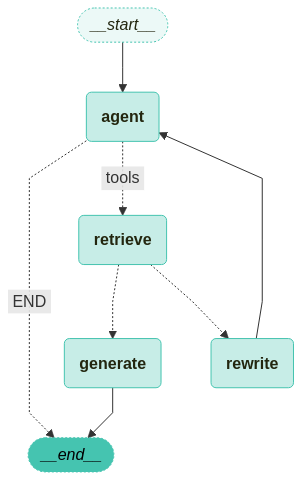

In [95]:
from utils.visualize import visualize_graph
visualize_graph(app)

In [105]:
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.errors import GraphRecursionError

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "4"})

inputs = {
    "messages": [
        HumanMessage(content="RAG와 Langchain의 차이"),
    ]
}

try:
    invoke_graph(app, inputs, config)
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_8FTvB6Q6wC8itUP6W88PCC6k)
 Call ID: call_8FTvB6Q6wC8itUP6W88PCC6k
  Args:
    query: RAG
  pdf_retriever (call_d9KYkDBUc7Z7Csang9W9IHuC)
 Call ID: call_d9KYkDBUc7Z7Csang9W9IHuC
  Args:
    query: Langchain
=== [DECISION: DOCS RELEVENT] ===

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: pdf_retriever

<document>
            <content>
                CLIP
Comparative Analysis of RAG
Frameworks
            </content>
            <metadata>
                <source>
                    data/RAGwithLangChain.pdf
                </source>
                <page>
                    7
                </page>
            </metadata>
        </document>

<document>
            <content>
                PART


In [102]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
messages = [HumanMessage(content="RAG와 Langchain의 차이")]
messages = app.invoke({"messages": messages}, config = config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

RAG와 Langchain의 차이
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_hiLwf1b5FqtuBxp21f4Ygn1v)
 Call ID: call_hiLwf1b5FqtuBxp21f4Ygn1v
  Args:
    query: RAG
  pdf_retriever (call_xOOLu5iTt9FT3h9KpXbPtlPk)
 Call ID: call_xOOLu5iTt9FT3h9KpXbPtlPk
  Args:
    query: Langchain
================================= Tool Message =================================
Name: pdf_retriever

<document>
            <content>
                CLIP
Comparative Analysis of RAG
Frameworks
            </content>
            <metadata>
                <source>
                    data/RAGwithLangChain.pdf
                </source>
                <page>
                    7
                </page>
            </metadata>
        </document>

<document>
            <content>
                PART
RAG with LangChain
            </content>
            <metadata>
       

In [106]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
inputs = {
    "messages": [
        ("user", "이영진이 누구야?"),
    ]
}

try:
    stream_graph(app, inputs, config, ["agent", "retrieve", "rewrite", "generate"])
    
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
🤖 [AI Message]
🤖 [AI Message]
🤖 [AI Message]
🤖 [AI Message]
🤖 [AI Message]
🤖 [AI Message]
🤖 [AI Message]
🤖 [AI Message]
🤖 [AI Message]

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
🤖 [AI Message]
🤖 [AI Message]
{"🤖 [AI Message]
binary🤖 [AI Message]
_score🤖 [AI Message]
":"🤖 [AI Message]
no🤖 [AI Message]
"}🤖 [AI Message]
🤖 [AI Message]
🤖 [AI Message]
=== [DECISION: DOCS IRRELEVENT] ===


NameError: name 'ToolMessage' is not defined

In [47]:
for step in app.stream(user_input, config=config):
    print("step:", step)
    for node_name, output in step.items():
        print("Node:", node_name)

step: {'agent': {'messages': [AIMessage(content='RAG는 Retrieval-Augmented Generation의 약자로, 정보 검색과 생성 모델을 결합하여 사용자 쿼리에 대한 답변을 생성하는 시스템입니다. 이 시스템은 사용자의 질문에 대해 관련 정보를 검색하고, 이를 바탕으로 자연어로 응답을 생성합니다. \n\n**출처**\n- data/RAGwithLangChain.pdf (페이지 10)', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'service_tier': 'default'}, id='run--1d6647b5-10c1-46e8-825c-8a7ac205a39f-0')]}}
Node: agent


### Where RAG is unnecessary

In [41]:
# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "대한민국의 수도는?"),
    ]
}
try:
    stream_graph(app, inputs, config, ["agent", "rewrite", "generate"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
대한민국의 수도는 서울입니다.

### Where it is impossible to get info from the docs using RAG

In [37]:
# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "내 이름을 알려줘"),
    ]
}
try:
    stream_graph(app, inputs, config, ["agent", "rewrite", "generate"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
죄송하지만, 현재로서는 귀하의 이름을 알 수 있는 정보가 없습니다. 이름을 알려주시면 그에 맞춰 대화할 수 있습니다!